<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkiBhasU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb

# Introduction: Unit 6 Project

Despite having international popularity, basketball's most popular league is the National Basketball Association, which is primarily based in America and Canada. It's a sport in which two opposing teams (with five players at any given point of time) drive down a court attempting to score points by either shooting a three pointer or two pointer, which depends on distance from the basket. Alternatively, teams can score by drawing a foul and shooting 'free throws', which are worth one point. There are 30 teams total in the NBA, with each team playing a total of 82 games in a season. Earlier, I mentioned there are 5 players at any time playing for a team. Each of those hold different 'positions' which take on different roles within the game: Center (C), Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF).

The most prized/well-playing players are commonly ranked based off the amount of points they score. However, they are a number of drivers that may affect this. To account and isolate such drivers, I wanted to find the best model for the data.

# Model

In [ ]:
#to begin with, I decided to combine this years data (24-25) into the original dataset
bb = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()
bb_R = pd.read_csv('https://raw.githubusercontent.com/Ankit-LASA/Data-Science/refs/heads/main/Untitled%20spreadsheet%20-%20Sheet1-2.csv').dropna()
merged_bb = pd.merge(bb, bb_R, on = 'Player')

In [ ]:
#condensing the data to realistic situations
merged_bb = merged_bb.query('MP_x > 600')
merged_bb = merged_bb.query('`FT%_x` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
merged_bb = merged_bb.query("Pos_x in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
merged_bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)
merged_bb

,Player,Pos_x,Age_x,Tm,G_x,GS_x,MP_x,FG_x,FGA_x,FG%_x,...,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y,Trp-Dbl,Player-additional_y
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,329,438,200,60,33,93,97,695,1,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,112,148,67,31,21,31,83,417,0,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,206,267,102,33,20,46,37,494,0,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,104,131,107,28,15,58,77,380,0,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,95,116,65,32,10,37,48,399,0,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,Zion Williamson,PF,23,NOP,70,70,2207,624,1094,0.570,...,63,100,58,13,16,41,37,278,0,willizi01
371,Jalen Wilson,PF,23,BRK,43,3,664,76,179,0.425,...,111,160,89,25,2,55,105,433,0,wilsoja03
372,James Wiseman,C,22,DET,63,6,1091,187,305,0.613,...,1,1,0,0,0,0,0,6,0,wisemja01
373,Delon Wright,PG,31,TOT,47,1,742,74,188,0.394,...,28,43,45,21,8,14,17,64,0,wrighde01


Next, I decided to pick attributes that may predict total points. My data set included a **litany** of items, including:



*   Position (Pos)
*   Games (G)
*   Ganes Started (GS)
*   Minutes Played (MP)
*   Field Goals (FG)
*   Field Goals Attempted (FGA)
*   Field Goal Percentage (FG%)
*   Three Point (3P)
*   Three Point Attempted (3PA)
*   Three Point Percentage (3P%)
*   Two Point (2P)
*   Two Point Attempted (2PA)
*   Two Point Percentage (2P%)
*   Effective Field Goal Percentage (eFG%)
*   Free Throw (FT)
*   Free Throw Attempted (FTA)
*   Free Throw Percentage (FT%)
*   Offensive Rebound (ORB)
*   Defensive Rebound (DRB)
*   Total Rebound (TRB)
*   Assists (AST)
*   Steals (STL)
*   Blocks (BLK)
*   Turnovers (TOV)
*   Personal Fouls (PF)
*   Points (PTS)

Because it would be silly to select all of the variables, as it would 'overfit' the model, I decided to select 4 of the more simple variables with a direct connection: minutes played, FT%, position, and FGA.

Output()

Output()

<Axes: xlabel='PTS_y'>

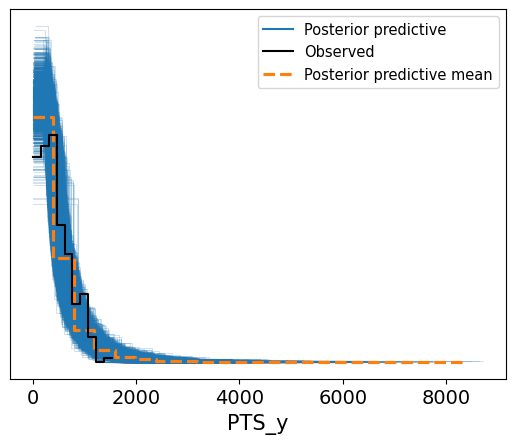

In [ ]:
#generic model to view all 4 variables as a base case
model_bb0 = bmb.Model("`PTS_y` ~ `MP_x` + Pos_x + 'FT%_x' + 'FGA_x'", data=merged_bb, family="negativebinomial")
idata_bb0 = model_bb0.fit(idata_kwargs={'log_likelihood': True})
model_bb0.predict(idata_bb0, kind="response")
az.plot_ppc(idata_bb0)

As a base case for the models, this model looks suprisingly good!

Next, I needed to choose models and test them to identify which is best to avoid overfitting while maintaining the most accuracy in the data.

In [ ]:
#basic model with minutes played and position
model_bb = bmb.Model("`PTS_y` ~ `MP_x` + Pos_x", data=merged_bb, family="negativebinomial")
idata_bb = model_bb.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
#basic model with minutes played and FT%
model_bb2 = bmb.Model("`PTS_y` ~ `MP_x` + 'FT%_x'", data=merged_bb, family="negativebinomial")
idata_bb2 = model_bb2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
#basic model with minutes played and FGA
model_bb3 = bmb.Model("`PTS_y` ~ `MP_x` + 'FGA_x'", data=merged_bb, family="negativebinomial")
idata_bb3 = model_bb3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
#basic model with position and FGA
model_bb4 = bmb.Model("`PTS_y` ~ `Pos_x` + 'FGA_x'", data=merged_bb, family="negativebinomial")
idata_bb4 = model_bb4.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
#heirarchical model
model_bb_h = bmb.Model("`PTS_y` ~ (`MP_x`|Pos_x)", data=merged_bb, family="negativebinomial")
idata_bb_h = model_bb_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#heirarchical model
model_bb_h2 = bmb.Model("`PTS_y` ~ (`MP_x`|'FT%_x')", data=merged_bb, family="negativebinomial")
idata_bb_h2 = model_bb_h2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
#heirarchical model
model_bb_h3 = bmb.Model("`PTS_y` ~ (`MP_x`|'FGA_x')", data=merged_bb, family="negativebinomial")
idata_bb_h3 = model_bb_h3.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 1 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:13

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#interactive model with minutes played and position
model_bb_i1 = bmb.Model("`PTS_y` ~ `MP_x`:Pos_x + 'MP_x' + Pos_x", data=merged_bb)
idata_bb_i1 = model_bb_i1.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:12

In [ ]:
#interactive model with FT% and position alongside a minutes played predictor
model_bb_i2 = bmb.Model("`PTS_y` ~ 'FT%_x':Pos_x + 'FT%_x' + Pos_x + 'MP_x'", data=merged_bb)
idata_bb_i2 = model_bb_i2.fit(idata_kwargs={'log_likelihood': True})


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:28

In [ ]:
#interactive model with minutes played, position, and FT%
model_bb_i3 = bmb.Model("`PTS_y` ~ `MP_x`:Pos_x + 'FT%_x':Pos_x + 'MP_x':'FT%_x' + 'FT%_x' + Pos_x + 'MP_x'", data=merged_bb)
idata_bb_i3 = model_bb_i3.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:39

In [23]:
#interactive model with FGA and position alongside a minutes played predictor
model_bb_i4 = bmb.Model("`PTS_y` ~ 'FGA_x':Pos_x + 'FGA_x' + Pos_x + 'MP_x'", data=merged_bb)
idata_bb_i4 = model_bb_i4.fit(idata_kwargs={'log_likelihood': True})


Output()

Output()

In [ ]:
#interactive model with FGA and MP
model_bb_i5 = bmb.Model("`PTS_y` ~ 'FGA_x':'MP_x' + 'FGA_x' + 'MP_x'", data=merged_bb)
idata_bb_i5 = model_bb_i5.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#interactive model with FGA and MP with a heirarchy for position
model_bb_i6 = bmb.Model("`PTS_y` ~ (('FGA_x':'MP_x')|'Pos_x') + 'FGA_x' + 'MP_x' + 'Pos_x'", data=merged_bb)
idata_bb_i6 = model_bb_i6.fit(idata_kwargs={'log_likelihood': True})

In [24]:
compare = az.compare({"Base Case":idata_bb0, "Normal: MP + Pos":idata_bb,"Normal: MP + FT%":idata_bb2, "Normal: MP + FGA":idata_bb3, "Normal: Position + FGA":idata_bb4, "Heirarchical: MP + Pos":idata_bb_h, "Heirarchical: MP + FT%":idata_bb_h2, "Heirarchical: MP + FGA":idata_bb_h3, "Interactive: MP + Pos":idata_bb_i1, "Interactive: FT% + Pos w/ MP":idata_bb_i2, "Interactive: MP + Pos + FT%":idata_bb_i3, "Interactive: FGA + Pos w/ MP":idata_bb_i4, "Interactive: FGA + MP":idata_bb_i5, "Interactive: FGA + MP w/ heirarchy for position":idata_bb_i6})
compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Interactive: FGA + MP,0,-1947.258499,6.331413,0.000000,6.017410e-01,14.864189,0.000000,False,log
Interactive: FGA + MP w/ heirarchy for position,1,-1948.987747,13.124649,1.729248,9.407626e-12,14.787133,2.544465,False,log
Interactive: FGA + Pos w/ MP,2,-1950.925302,14.249714,3.666804,9.658473e-12,14.785585,3.199229,False,log
Normal: MP + FGA,3,-1954.728360,4.041882,7.469861,0.000000e+00,13.923876,11.845682,False,log
Normal: Position + FGA,4,-1955.710716,6.500039,8.452217,3.925354e-01,13.620483,12.199108,False,log
Base Case,5,-1957.432288,8.333571,10.173790,8.524044e-12,13.814385,12.219858,False,log
Normal: MP + FT%,6,-1972.373427,4.346304,25.114928,7.890471e-12,14.173837,13.180287,False,log
Normal: MP + Pos,7,-1974.219078,6.967088,26.960580,7.553852e-12,14.647125,13.592532,False,log
Heirarchical: MP + Pos,8,-1975.473233,9.735118,28.214735,7.713849e-12,14.764372,13.708952,False,log
Interactive: MP + Pos,9,-1993.331937,10.968866,46.073439,1.283196e-11,13.803165,11.012606,False,log


<Axes: xlabel='PTS_y'>

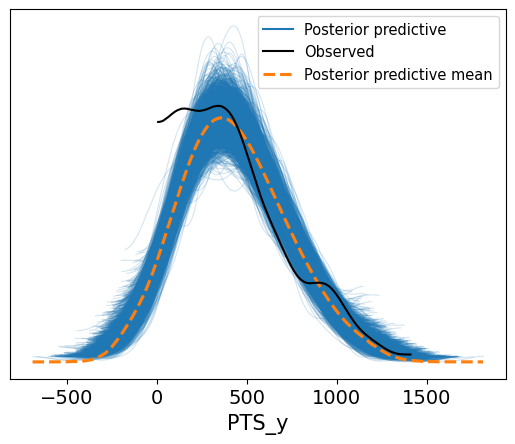

In [27]:
#final model
model_bb_i5.predict(idata_bb_i5, kind="response")
az.plot_ppc(idata_bb_i5)

# Conclusion

Looking at the litany of models and ELPD_loo values, I believe the most accurate model is the one with an interactive between Field Goal Attempts (FGA) and Minutes Played (MP)---which I dubbed in the code as 'i5'.

First, it had the best elpd_loo value of the collective models. After testing a combination of the other models, i5 tracked the dataset most accurately. Additionally, even though there's other models with similar elpd_loo values, those models have much more variables than i5.

Second, the casual diagram (DAG) I drew indicated that FGA and MP was the simplest method to account for the data. While all 4 variables had a correlation with points, they didn't necessarily represent perfect indicators. A good free throw % doesn't necessarily translate to points because those players may not have much play time or they may be worse at shooting field goals. Additionally, position fails to translate to points in some instances--which is confirmed by how some of the best players in the NBA, particularly Jokic, are centers with extremely high average scoring.

Obviously, the model isn't perfect (which is demonstrated by the last PPC), but it's accurately fitted to the data without relying on too many variables. Importantly, it fits with underlying knowledge that I have of the NBA (which acts as a prior in the model) and matches with the least complex version of the casual DAG, so I have a higher level of confidence as a predictor of data. It's essential to note that every player is different, so a high amount of FGA or MP may not necessarily tranlsate to higher points. For example, a more efficient player who shoots more accurately **can** have more points. As such, even the best model should have an asterisk on its effectiveness.